In [1]:
#Original code https://www.kaggle.com/ashishpatel26/1-23-pb-first-try-to-think
import pandas as pd
import numpy as np

# DRAGONS
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

# plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pandas / plt options
pd.options.display.max_columns = 999
plt.rcParams['figure.figsize'] = (14, 7)
font = {'family' : 'verdana',
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# remove warnings
import warnings
warnings.simplefilter("ignore")

# garbage collector
import gc
gc.enable()

In [2]:
#загружаем не оригинальные данные, а предобработанные 
#https://www.kaggle.com/ogrellier/create-extracted-json-fields-dataset

In [3]:
train = pd.read_csv('create-extracted-json-fields-dataset/extracted_fields_train.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
test = pd.read_csv('create-extracted-json-fields-dataset/extracted_fields_test.gz', dtype={'date': str, 'fullVisitorId': str, 'sessionId':str, 'visitId': np.int64})
train.shape, test.shape

((903653, 30), (804684, 30))

In [4]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1.0,1.472830e+09,Chrome,desktop,0.0,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1.0,1.472880e+09,Firefox,desktop,0.0,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1.0,1.472865e+09,Chrome,desktop,0.0,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1.0,1.472881e+09,UC Browser,desktop,0.0,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2.0,1.472823e+09,Chrome,mobile,1.0,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1.0,NaN,1.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google


In [5]:
train.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source'],
      dtype='object')

In [6]:
# Getting data from leak
train_store_1 = pd.read_csv('exported-google-analytics-data/Train_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
train_store_2 = pd.read_csv('exported-google-analytics-data/Train_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_1 = pd.read_csv('exported-google-analytics-data/Test_external_data.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})
test_store_2 = pd.read_csv('exported-google-analytics-data/Test_external_data_2.csv', low_memory=False, skiprows=6, dtype={"Client Id":'str'})

In [7]:
# Getting VisitId from Google Analytics...
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    df["visitId"] = df["Client Id"].apply(lambda x: x.split('.', 1)[1]).astype(np.int64)

In [8]:
# Merge with train/test data
train = train.merge(pd.concat([train_store_1, train_store_2], sort=False), how="left", on="visitId")
test = test.merge(pd.concat([test_store_1, test_store_2], sort=False), how="left", on="visitId")

# Drop Client Id
for df in [train, test]:
    df.drop("Client Id", 1, inplace=True)

In [9]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1.0,1.472830e+09,Chrome,desktop,0.0,Windows,Izmir,Asia,Turkey,(not set),ttnet.com.tr,Izmir,Western Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1.0,1.472880e+09,Firefox,desktop,0.0,Macintosh,not available in demo dataset,Oceania,Australia,not available in demo dataset,dodo.net.au,not available in demo dataset,Australasia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1.0,1.472865e+09,Chrome,desktop,0.0,Windows,Madrid,Europe,Spain,(not set),unknown.unknown,Community of Madrid,Southern Europe,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1.0,1.472881e+09,UC Browser,desktop,0.0,Linux,not available in demo dataset,Asia,Indonesia,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,NaN,NaN,(not set),NaN,google + online,organic,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2.0,1.472823e+09,Chrome,mobile,1.0,Android,not available in demo dataset,Europe,United Kingdom,not available in demo dataset,unknown.unknown,not available in demo dataset,Northern Europe,1.0,1.0,NaN,1.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train.columns


Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.bounces', 'totals.hits',
       'totals.newVisits', 'totals.pageviews', 'totals.transactionRevenue',
       'trafficSource.adContent', 'trafficSource.campaign',
       'trafficSource.isTrueDirect', 'trafficSource.keyword',
       'trafficSource.medium', 'trafficSource.referralPath',
       'trafficSource.source', 'Sessions', 'Avg. Session Duration',
       'Bounce Rate', 'Revenue', 'Transactions', 'Goal Conversion Rate'],
      dtype='object')

In [11]:
# Cleaning Revenue
for df in [train, test]:
    df["Revenue"].fillna('$', inplace=True)
    df["Revenue"] = df["Revenue"].apply(lambda x: x.replace('$', '').replace(',', ''))
    df["Revenue"] = pd.to_numeric(df["Revenue"], errors="coerce")
    df["Revenue"].fillna(0.0, inplace=True)

In [12]:
for df in [train_store_1, train_store_2, test_store_1, test_store_2]:
    del df
gc.collect()

32

Looking around
Some pictures to have in mind: target distribution

In [13]:
target_sums = train.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

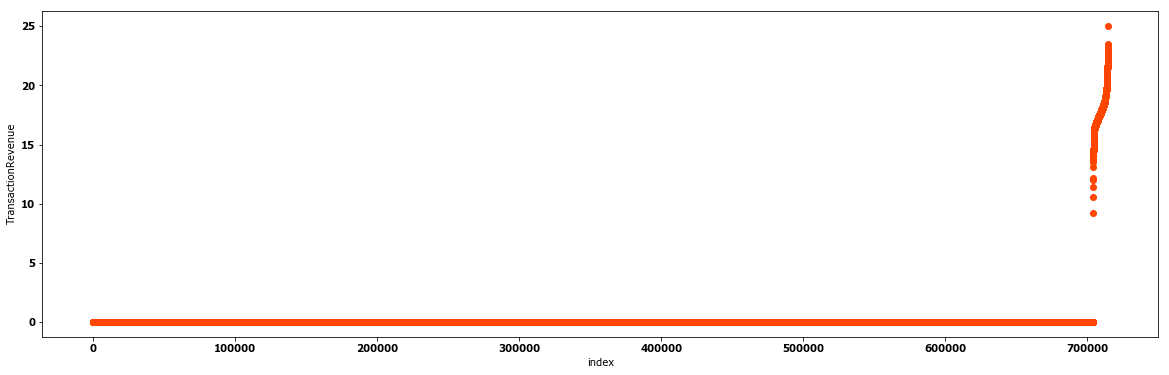

In [14]:
plt.figure(figsize=(20,6))
plt.scatter(range(target_sums.shape[0]), np.sort(np.log1p(target_sums["totals.transactionRevenue"].values)), color = "#ff4500")
plt.xlabel('index')
plt.ylabel('TransactionRevenue')
plt.show()

Key problem:

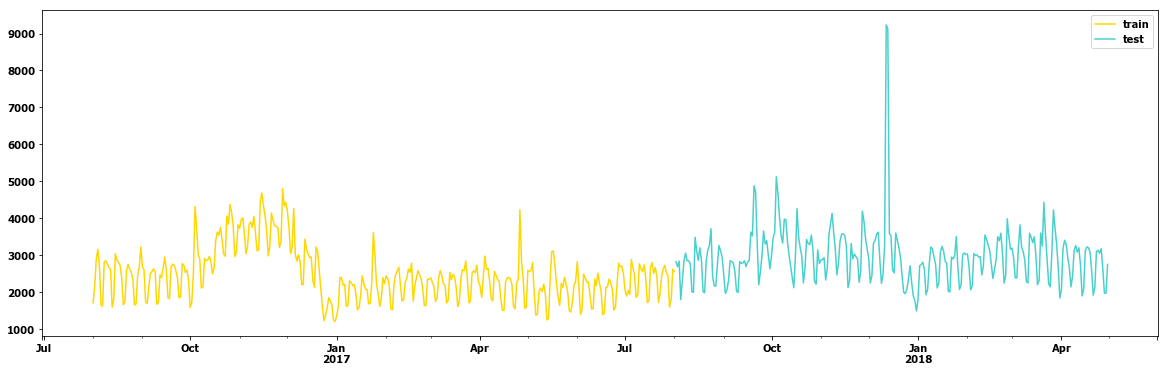

In [15]:
train.date = pd.to_datetime(train.date, format="%Y%m%d")
test.date = pd.to_datetime(test.date, format="%Y%m%d")
plt.figure(figsize=(20,6))
train.date.value_counts().sort_index().plot(label="train", color = "#FFD700")
test.date.value_counts().sort_index().plot(label="test", color = "#48D1CC")
plt.legend()

Comparing categories in train and test:

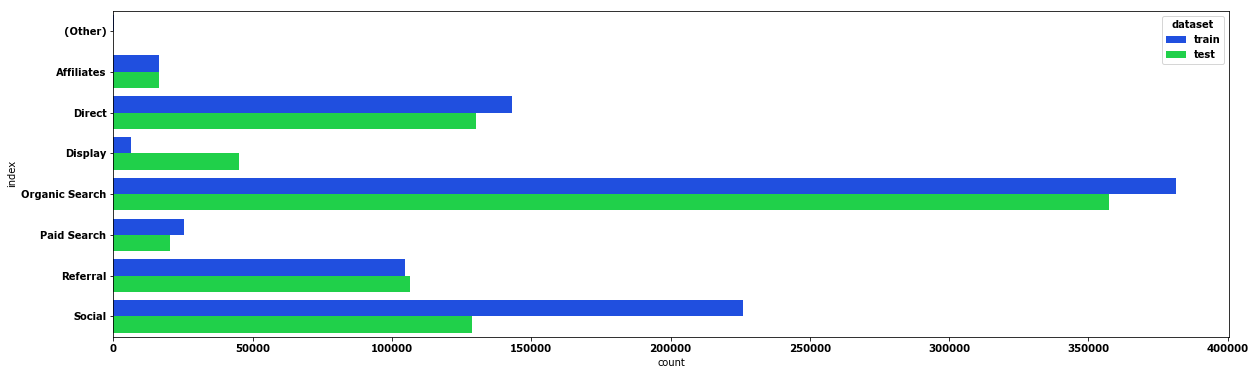

In [16]:
palette = sns.color_palette("bright")

# Use palplot and pass in the variable:
# sns.palplot(palette)

def drawBars(columnname):
    plt.figure(figsize=(20,6))
    sns.barplot(x="count", y="index", hue="dataset",data=pd.melt(pd.concat([train[columnname].value_counts().rename("train"), 
                                                                            test[columnname].value_counts().rename("test")], axis=1, sort="False").reset_index(), 
                                                                 id_vars="index", var_name="dataset", value_name="count"),palette=palette)

drawBars("channelGrouping")

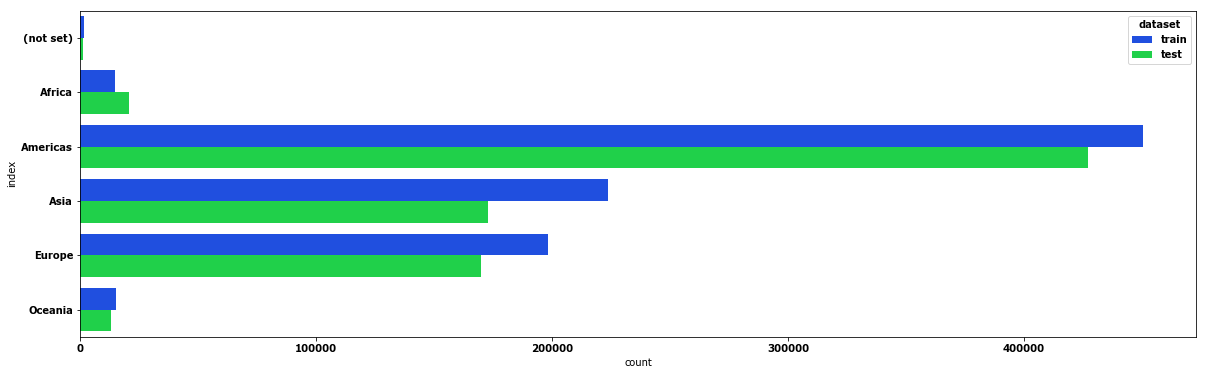

In [17]:
drawBars("geoNetwork.continent")

In [18]:
ids_train = set(train.fullVisitorId.unique())
ids_test = set(test.fullVisitorId.unique())
print("Unique visitor ids in train:", len(ids_train))
print("Unique visitor ids in test:", len(ids_test))
print("Common visitors in train and test:", len(ids_train & ids_test))

Unique visitor ids in train: 714167
Unique visitor ids in test: 617242
Common visitors in train and test: 7679


In [19]:
#Weird "double" sessions:
problem = train[train.sessionId.map(train.sessionId.value_counts() == 2)].sort_values(["sessionId", 'visitStartTime'])
problem.head(10)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
212027,Organic Search,2016-08-21,0011338928267756760,0011338928267756760_1471848731,1471848731,1.0,1.471849e+09,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
82177,Organic Search,2016-08-22,0011338928267756760,0011338928267756760_1471848731,1471848731,1.0,1.471849e+09,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,China,not available in demo dataset,unknown.unknown,not available in demo dataset,Eastern Asia,NaN,2.0,1.0,1.0,NaN,NaN,(not set),NaN,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
848580,Referral,2016-12-31,0014884852016449602,0014884852016449602_1483257533,1483257533,2.0,1.483258e+09,Chrome,desktop,0.0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,1.0,1.0,NaN,1.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
802550,Referral,2017-01-01,0014884852016449602,0014884852016449602_1483257533,1483257533,2.0,1.483258e+09,Chrome,desktop,0.0,Macintosh,Los Angeles,Americas,United States,Los Angeles CA,(not set),California,Northern America,NaN,10.0,NaN,6.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
428608,Organic Search,2017-06-05,0019612470994343873,0019612470994343873_1496731675,1496731675,24.0,1.496732e+09,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,14.0,NaN,14.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
202288,Organic Search,2017-06-06,0019612470994343873,0019612470994343873_1496731675,1496731675,24.0,1.496732e+09,Chrome,desktop,0.0,Macintosh,Mountain View,Americas,United States,San Francisco-Oakland-San Jose CA,comcast.net,California,Northern America,NaN,2.0,NaN,2.0,NaN,NaN,(not set),1.0,(not provided),organic,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
46654,Paid Search,2017-05-19,0031542961723593073,0031542961723593073_1495261490,1495261490,1.0,1.495261e+09,Chrome,tablet,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,37.0,1.0,32.0,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
857847,Paid Search,2017-05-20,0031542961723593073,0031542961723593073_1495261490,1495261490,1.0,1.495264e+09,Chrome,tablet,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,comcast.net,not available in demo dataset,Northern America,NaN,5.0,1.0,4.0,NaN,{KeyWord:Google Brand Items},AW - Accessories,NaN,+google +tshirt +store,cpc,NaN,google,NaN,NaN,NaN,0.0,NaN,NaN
618668,Referral,2017-01-24,0039798900163330977,0039798900163330977_1485331011,1485331011,4.0,1.485331e+09,Chrome,desktop,0.0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(not set),Southeast Asia,NaN,5.0,NaN,5.0,NaN,NaN,(not set),1.0,NaN,referral,/,mall.googleplex.com,NaN,NaN,NaN,0.0,NaN,NaN
520543,Referral,2017-01-25,0039798900163330977,0039798900163330977_1485331011,1485331011,4.0,1.485331e+09,Chrome,desktop,0.0,Macintosh,(not set),Asia,Singapore,(not set),(not set),(no

True     898945
False      4709
dtype: int64


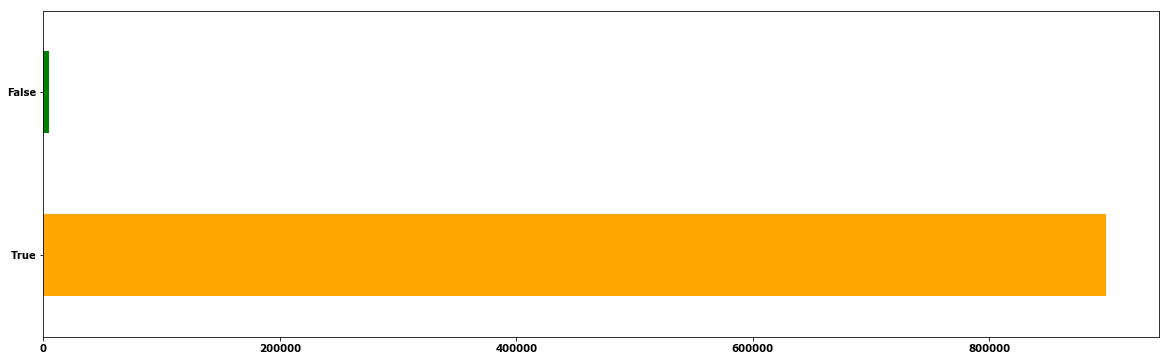

In [20]:
#VisitStartTime seems to be same thing as visitId... yet not always!
plt.figure(figsize=(20,6))
print((train.visitStartTime == train.visitId).value_counts())
(train.visitStartTime == train.visitId).value_counts().plot.barh(color = ["orange","green"])

In [21]:
#Suspicious simultaneous visitors with same visitorId and same visitStartTime:
train.loc[pd.to_datetime(train.visitStartTime, unit='s') == "2017-04-25 18:49:35"].head(8)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
258149,Direct,2017-04-25,2416319035096969159,2416319035096969159_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,2.0,1.0,2.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258251,Direct,2017-04-25,5875467051006180209,5875467051006180209_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,4.0,1.0,4.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258415,Direct,2017-04-25,3888067253787916439,3888067253787916439_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,7.0,1.0,7.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258455,Direct,2017-04-25,0579533224601930433,0579533224601930433_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,8.0,1.0,8.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258470,Direct,2017-04-25,956161522071607688,956161522071607688_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,9.0,1.0,9.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258523,Direct,2017-04-25,2943475894610901056,2943475894610901056_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,12.0,1.0,12.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
258583,Direct,2017-04-25,715403851793675702,715403851793675702_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,16.0,1.0,8.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN
259881,Direct,2017-04-25,2234027337409555263,2234027337409555263_1493146175,1493146175,1.0,1.493146e+09,Chrome,desktop,0.0,Chrome OS,Buenos Aires,Americas,Argentina,(not set),(not set),Buenos Aires,South America,NaN,3.0,1.0,3.0,NaN,NaN,(not set),1.0,NaN,(none),NaN,(direct),NaN,NaN,NaN,0.0,NaN,NaN


In [22]:
#Seems to be a serious problem:
print("Train: ", np.bincount(train.visitId.value_counts()))

Train:  [     0 869451  16411    396     38      3      3      0      1]


In [23]:
print("test: ", np.bincount(test.visitId.value_counts()))

test:  [     0 759983  17804    978    262    110     62     36     18     17
     24     12     15     24     22     24     19     21     21     23
      9      8      5      2      2      0      1      0      2]


Preprocessing

In [24]:
#Setting time as index and saving time as feature (for FE purposes only)
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
test.visitStartTime = pd.to_datetime(test.visitStartTime, unit='s')
train["date"] = train.visitStartTime
test["date"] = test.visitStartTime

In [25]:
train.set_index("visitStartTime", inplace=True)
test.set_index("visitStartTime", inplace=True)
train.sort_index(inplace=True)
test.sort_index(inplace=True)

Clearing rare categories and setting 0 to NaNs:



In [26]:
def clearRare(columnname, limit = 1000):
    # you may search for rare categories in train, train&test, or just test
    vc = pd.concat([train[columnname], test[columnname]], sort=False).value_counts()
    #vc = test[columnname].value_counts()
    
    common = vc > limit
    common = set(common.index[common].values)
    print("Set", sum(vc <= limit), columnname, "categories to 'other';", end=" ")
    
    train.loc[train[columnname].map(lambda x: x not in common), columnname] = 'other'
    test.loc[test[columnname].map(lambda x: x not in common), columnname] = 'other'
    print("now there are", train[columnname].nunique(), "categories in train")

In [27]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

In [28]:
clearRare("device.browser")
clearRare("device.operatingSystem")
clearRare("geoNetwork.country")
clearRare("geoNetwork.city")
clearRare("geoNetwork.metro")
clearRare("geoNetwork.networkDomain")
clearRare("geoNetwork.region")
clearRare("geoNetwork.subContinent")
clearRare("trafficSource.adContent")
clearRare("trafficSource.campaign")
clearRare("trafficSource.keyword")
clearRare("trafficSource.medium")
clearRare("trafficSource.referralPath")
clearRare("trafficSource.source")

Set 115 device.browser categories to 'other'; now there are 14 categories in train
Set 16 device.operatingSystem categories to 'other'; now there are 9 categories in train
Set 147 geoNetwork.country categories to 'other'; now there are 82 categories in train
Set 853 geoNetwork.city categories to 'other'; now there are 104 categories in train
Set 97 geoNetwork.metro categories to 'other'; now there are 27 categories in train
Set 41850 geoNetwork.networkDomain categories to 'other'; now there are 133 categories in train
Set 391 geoNetwork.region categories to 'other'; now there are 92 categories in train
Set 4 geoNetwork.subContinent categories to 'other'; now there are 20 categories in train
Set 70 trafficSource.adContent categories to 'other'; now there are 5 categories in train
Set 27 trafficSource.campaign categories to 'other'; now there are 5 categories in train
Set 5381 trafficSource.keyword categories to 'other'; now there are 12 categories in train
Set 1 trafficSource.medium cat

In [29]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,Direct,2016-08-01 07:00:12,0423043652415339154,0423043652415339154_1470034812,1470034812,3.0,Safari,mobile,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1.0,1.0,0.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0,0.0,0.0,0
2016-08-01 07:04:26,Social,2016-08-01 07:04:26,8294721032567046680,8294721032567046680_1470035066,1470035066,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,Thailand,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,0.0,0,(not set),0.0,0,referral,/yt/about/,youtube.com,0.0,0,0,0.0,0.0,0
2016-08-01 07:04:41,Organic Search,2016-08-01 07:04:41,7718623669497357235,7718623669497357235_1470035081,1470035081,1.0,Amazon Silk,tablet,1.0,Android,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,0.0,5.0,1.0,5.0,0.0,0,(not set),0.0,(not provided),organic,0,google,0.0,0,0,0.0,0.0,0
2016-08-01 07:06:01,Organic Search,2016-08-01 07:06:01,4798058133221713505,4798058133221713505_1470035161,1470035161,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Americas,Canada,not available in demo dataset,bell.ca,not available in demo dataset,Northern America,0.0,9.0,1.0,7.0,0.0,0,(not set),0.0,(not provided),organic,0,google,0.0,0,0,0.0,0.0,0
2016-08-01 07:06:10,Direct,2016-08-01 07:06:10,5076747981380011349,5076747981380011349_1470035170,1470035170,1.0,Chrome,desktop,0.0,Windows,Quezon City,Asia,Philippines,(not set),pldt.net,Metro Manila,Southeast Asia,1.0,1.0,1.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0,0.0,0.0,0


In [30]:
# Clearing leaked data:
for df in [train, test]:
    df["Avg. Session Duration"][df["Avg. Session Duration"] == 0] = "00:00:00"
    df["Avg. Session Duration"] = df["Avg. Session Duration"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))
    df["Bounce Rate"] = df["Bounce Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)
    df["Goal Conversion Rate"] = df["Goal Conversion Rate"].astype(str).apply(lambda x: x.replace('%', '')).astype(float)

Features

In [31]:
#Based on strange things in dataset:

In [32]:
for df in [train, test]:
    # remember these features were equal, but not always? May be it means something...
    df["id_incoherence"] = pd.to_datetime(df.visitId, unit='s') != df.date
    # remember visitId dublicates?
    df["visitId_dublicates"] = df.visitId.map(df.visitId.value_counts())
    # remember session dublicates?
    df["session_dublicates"] = df.sessionId.map(df.sessionId.value_counts())

In [33]:
#Basic time features:
for df in [train, test]:
    df['weekday'] = df['date'].dt.dayofweek.astype(object)
    df['time'] = df['date'].dt.second + df['date'].dt.minute*60 + df['date'].dt.hour*3600
    #df['month'] = df['date'].dt.month   # it must not be included in features during learning!
    df['day'] = df['date'].dt.day       # it must not be included in features during learning!

Looking to future features (from https://www.kaggle.com/ashishpatel26/future-is-here):

In [34]:
df = pd.concat([train, test])
df.sort_values(['fullVisitorId', 'date'], ascending=True, inplace=True)
df['prev_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(1)).astype(np.int64) // 1e9 // 60 // 60
df['next_session'] = (df['date'] - df[['fullVisitorId', 'date']].groupby('fullVisitorId')['date'].shift(-1)).astype(np.int64) // 1e9 // 60 // 60
df.sort_index(inplace=True)

train = df[:len(train)]
test = df[len(train):]

In [35]:
#Paired categories from "teach-lightgbm-to-sum-predictions" kernel

In [36]:
for df in [train, test]:
    df['source.country'] = df['trafficSource.source'] + '_' + df['geoNetwork.country']
    df['campaign.medium'] = df['trafficSource.campaign'] + '_' + df['trafficSource.medium']
    df['browser.category'] = df['device.browser'] + '_' + df['device.deviceCategory']
    df['browser.os'] = df['device.browser'] + '_' + df['device.operatingSystem']

In [37]:
for df in [train, test]:
    df['device_deviceCategory_channelGrouping'] = df['device.deviceCategory'] + "_" + df['channelGrouping']
    df['channelGrouping_browser'] = df['device.browser'] + "_" + df['channelGrouping']
    df['channelGrouping_OS'] = df['device.operatingSystem'] + "_" + df['channelGrouping']
    
    for i in ['geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country','geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region','geoNetwork.subContinent']:
        for j in ['device.browser','device.deviceCategory', 'device.operatingSystem', 'trafficSource.source']:
            df[i + "_" + j] = df[i] + "_" + df[j]
    
    df['content.source'] = df['trafficSource.adContent'].astype(str) + "_" + df['source.country']
    df['medium.source'] = df['trafficSource.medium'] + "_" + df['source.country']

In [38]:
#User-aggregating features:
for feature in ["totals.hits", "totals.pageviews"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].mean()
    train["usermean_" + feature] = train.fullVisitorId.map(info)
    test["usermean_" + feature] = test.fullVisitorId.map(info)
    
for feature in ["visitNumber"]:
    info = pd.concat([train, test], sort=False).groupby("fullVisitorId")[feature].max()
    train["usermax_" + feature] = train.fullVisitorId.map(info)
    test["usermax_" + feature] = test.fullVisitorId.map(info)

In [39]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,weekday,time,day,prev_session,next_session,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,Direct,2016-08-01 07:00:12,0423043652415339154,0423043652415339154_1470034812,1470034812,3.0,Safari,mobile,1.0,iOS,not available in demo dataset,Americas,United States,not available in demo dataset,(not set),not available in demo dataset,Northern America,1.0,1.0,0.0,1.0,0.0,0,(not set),1.0,0,(none),0,(direct),0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25212,1,-2562048,-2562048,(direct)_United States,(not set)_(none),Safari_mobile,Safari_iOS,mobile_Direct,Safari_Direct,iOS_Direct,not available in demo dataset_Safari,not available in demo dataset_mobile,not available in demo dataset_iOS,not available in demo dataset_(direct),Americas_Safari,Americas_mobile,Americas_iOS,Americas_(direct),United States_Safari,United States_mobile,United States_iOS,United States_(direct),not available in demo dataset_Safari,not available in demo dataset_mobile,not available in demo dataset_iOS,not available in demo dataset_(direct),(not set)_Safari,(not set)_mobile,(not set)_iOS,(not set)_(direct),not available in demo dataset_Safari,not available in demo dataset_mobile,not available in demo dataset_iOS,not available in demo dataset_(direct),Northern America_Safari,Northern America_mobile,Northern America_iOS,Northern America_(direct),0_(direct)_United States,(none)_(direct)_United States,1.0,1.0,3.0
2016-08-01 07:04:26,Social,2016-08-01 07:04:26,8294721032567046680,8294721032567046680_1470035066,1470035066,1.0,Chrome,desktop,0.0,Windows,not available in demo dataset,Asia,Thailand,not available in demo dataset,unknown.unknown,not available in demo dataset,Southeast Asia,1.0,1.0,1.0,1.0,0.0,0,(not set),0.0,0,referral,/yt/about/,youtube.com,0.0,0,0.0,0.0,0.0,0.0,False,1,1,0,25466,1,-2562048,-2562048,youtube.com_Thailand,(not set)_referral,Chrome_desktop,Chrome_Windows,desktop_Social,Chrome_Social,Windows_S

**Encoding features**

In [40]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', 
            'month', 'day', 'help']

cat_cols = [f for f in train.columns if (train[f].dtype == 'object' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [41]:
train[cat_cols].nunique()<60

channelGrouping                                     True
device.browser                                      True
device.deviceCategory                               True
device.operatingSystem                              True
geoNetwork.city                                    False
geoNetwork.continent                                True
geoNetwork.country                                 False
geoNetwork.metro                                    True
geoNetwork.networkDomain                           False
geoNetwork.region                                  False
geoNetwork.subContinent                             True
trafficSource.adContent                             True
trafficSource.campaign                              True
trafficSource.keyword                               True
trafficSource.medium                                True
trafficSource.referralPath                          True
trafficSource.source                                True
weekday                        

In [42]:
real_cols

['visitNumber',
 'device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.isTrueDirect',
 'Sessions',
 'Avg. Session Duration',
 'Bounce Rate',
 'Revenue',
 'Transactions',
 'Goal Conversion Rate',
 'id_incoherence',
 'visitId_dublicates',
 'session_dublicates',
 'time',
 'prev_session',
 'next_session',
 'usermean_totals.hits',
 'usermean_totals.pageviews',
 'usermax_visitNumber']

In [48]:
#train1 = train.copy()
#test1 = test.copy()

In [44]:
#cat_cols

In [45]:
#del(train2)

In [46]:
#del(df)

In [43]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # OHE так не раотает
for col in cat_cols:
    lbl = LabelEncoder()
    lbl.fit(list(train[col].values.astype('str')) + list(test[col].values.astype('str')))
    train[col] = lbl.transform(list(train[col].values.astype('str')))
    test[col] = lbl.transform(list(test[col].values.astype('str')))

In [44]:
for col in real_cols:
    train[col] = train[col].astype(float)
    test[col] = test[col].astype(float)

In [45]:
train[real_cols + cat_cols].head()

,visitNumber,device.isMobile,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,trafficSource.isTrueDirect,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,time,prev_session,next_session,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber,channelGrouping,device.browser,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.adContent,trafficSource.campaign,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,weekday,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,3.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25212.0,-2562048.0,-2562048.0,1.0,1.0,3.0,2,9,1,7,102,2,77,25,0,91,9,0,1,4,0,52,0,0,77,1,30,45,10,76,57,1184,307,805,2146,38,7,25,48,1005,232,666,1642,313,76,199,615,9,1,7,0,1091,274,734,1885,136,28,88,208,77,77
2016-08-01 07:04:26,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25466.0,-2562048.0,-2562048.0,1.0,1.0,1.0,7,2,0,5,102,3,71,25,109,91,12,0,1,4,6,23,27,0,1739,7,5,7,7,21,54,1177,306,803,2173,46,9,32,103,917,213,610,1534,306,75,197,642,1220,326,875,2198,1084,273,732,1912,174,36,113,318,1739,1919
2016-08-01 07:04:41,1.0,1.0,0.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25481.0,-2562048.0,-2562048.0,5.0,5.0,1.0,4,0,2,1,102,2,77,25,0,91,9,0,1,3,4,52,9,0,727,5,1,0,20,3,12,1175,308,799,2155,29,8,19,57,996,233,660,1651,304,77,193,624,0,2,1,9,1082,275,728,1894,127,29,82,217,727,500
2016-08-01 07:06:01,1.0,0.0,0.0,9.0,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25561.0,-2562048.0,-2562048.0,9.0,7.0,1.0,4,2,0,5,102,2,11,25,16,91,9,0,1,3,4,52,9,0,661,5,5,7,4,18,51,1177,306,803,2155,31,6,23,57,149,33,102,238,306,75,197,624,181,48,139,327,1084,273,732,1894,129,27,86,217,661,434
2016-08-01 07:06:10,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,25570.0,-2562048.0,-2562048.0,1.0,1.0,1.0,2,2,0,5,75,3,53,0,67,52,12,0,1,4,0,52,0,0,53,1,5,7,2,16,49,873,225,601,1563,46,9,32,76,684,159,455,1109,2,0,5,0,749,200,532,1330,622,156,424,1041,174,36,113,291,53,53


In [46]:
for to_del in ["date", "sessionId", "visitId", "day"]:
    del train[to_del]
    del test[to_del]

**Preparing validation**

In [47]:
excluded = ['date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'visitId', 'visitStartTime', "month", "help"]

cat_cols = [f for f in train.columns if (train[f].dtype == 'int64' and f not in excluded)]
real_cols = [f for f in train.columns if (not f in cat_cols and f not in excluded)]

In [48]:
real_cols

['visitNumber',
 'device.isMobile',
 'totals.bounces',
 'totals.hits',
 'totals.newVisits',
 'totals.pageviews',
 'trafficSource.isTrueDirect',
 'Sessions',
 'Avg. Session Duration',
 'Bounce Rate',
 'Revenue',
 'Transactions',
 'Goal Conversion Rate',
 'id_incoherence',
 'visitId_dublicates',
 'session_dublicates',
 'time',
 'prev_session',
 'next_session',
 'usermean_totals.hits',
 'usermean_totals.pageviews',
 'usermax_visitNumber']

In [49]:
#Function to tell us the score using the metric we actually care about
from sklearn.metrics import mean_squared_error
def score(data, y):
    validation_res = pd.DataFrame(
    {"fullVisitorId": data["fullVisitorId"].values,
     "transactionRevenue": data["totals.transactionRevenue"].values,
     "predictedRevenue": np.expm1(y)})

    validation_res = validation_res.groupby("fullVisitorId")["transactionRevenue", "predictedRevenue"].sum().reset_index()
    return np.sqrt(mean_squared_error(np.log1p(validation_res["transactionRevenue"].values), 
                                     np.log1p(validation_res["predictedRevenue"].values)))

In [50]:
unique_vis = np.array(sorted(train['fullVisitorId'].astype(str).unique()))

In [51]:
len(unique_vis)

714167

In [52]:
train.shape

(903654, 79)

In [53]:
#Cute function to validate and prepare stacking
from sklearn.model_selection import GroupKFold

class KFoldValidation():
    def __init__(self, data, n_splits=5):
        unique_vis = np.array(sorted(data['fullVisitorId'].astype(str).unique()))
        folds = GroupKFold(n_splits)
        ids = np.arange(data.shape[0])
        
        self.fold_ids = []
        for trn_vis, val_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            self.fold_ids.append([
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[trn_vis])],
                    ids[data['fullVisitorId'].astype(str).isin(unique_vis[val_vis])]
                ])
            
    def validate(self, train, test, features, model, name="", prepare_stacking=False, 
                 fit_params={"early_stopping_rounds": 50, "verbose": 100, "eval_metric": "rmse"}):
        model.FI = pd.DataFrame(index=features)
        full_score = 0
        
        if prepare_stacking:
            test[name] = 0
            train[name] = np.NaN
        
        for fold_id, (trn, val) in enumerate(self.fold_ids):
            devel = train[features].iloc[trn]
            y_devel = np.log1p(train["totals.transactionRevenue"].iloc[trn])
            valid = train[features].iloc[val]
            y_valid = np.log1p(train["totals.transactionRevenue"].iloc[val])
                       
            print("Fold ", fold_id, ":")
            model.fit(devel, y_devel, eval_set=[(valid, y_valid)], **fit_params)
            
            if len(model.feature_importances_) == len(features):  # some bugs in catboost?
                model.FI['fold' + str(fold_id)] = model.feature_importances_ / model.feature_importances_.sum()

            predictions = model.predict(valid)
            predictions[predictions < 0] = 0
            print("Fold ", fold_id, " error: ", mean_squared_error(y_valid, predictions)**0.5)
            
            fold_score = score(train.iloc[val], predictions)
            full_score += fold_score / len(self.fold_ids)
            print("Fold ", fold_id, " score: ", fold_score)
            
            if prepare_stacking:
                train[name].iloc[val] = predictions
                
                test_predictions = model.predict(test[features])
                test_predictions[test_predictions < 0] = 0
                test[name] += test_predictions / len(self.fold_ids)
                
        print("Final score: ", full_score)
        return full_score

In [54]:
Kfolder = KFoldValidation(train)

In [55]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1500, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.75, feature_fraction=0.55, bagging_frequency=6, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [56]:
train.head()

,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,weekday,time,prev_session,next_session,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,2,0423043652415339154,3.0,9,1,1.0,7,102,2,77,25,0,91,9,1.0,1.0,0.0,1.0,0.0,0,1,1.0,4,0,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25212.0,-2562048.0,-2562048.0,77,1,30,45,10,76,57,1184,307,805,2146,38,7,25,48,1005,232,666,1642,313,76,199,615,9,1,7,0,1091,274,734,1885,136,28,88,208,77,77,1.0,1.0,3.0
2016-08-01 07:04:26,7,8294721032567046680,1.0,2,0,0.0,5,102,3,71,25,109,91,12,1.0,1.0,1.0,1.0,0.0,0,1,0.0,4,6,23,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25466.0,-2562048.0,-2562048.0,1739,7,5,7,7,21,54,1177,306,803,2173,46,9,32,103,917,213,610,1534,306,75,197,642,1220,326,875,2198,1084,273,732,1912,174,36,113,318,1739,1919,1.0,1.0,1.0
2016-08-01 07:04:41,4,7718623669497357235,1.0,0,2,1.0,1,102,2,77,25,0,91,9,0.0,5.0,1.0,5.0,0.0,0,1,0.0,3,4,52,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25481.0,-2562048.0,-2562048.0,727,5,1,0,20,3,12,1175,308,799,2155,29,8,19,57,996,233,660,1651,304,77,193,624,0,2,1,9,1082,275,728,1894,127,29,82,217,727,500,5.0,5.0,1.0
2016-08-01 07:06:01,4,4798058133221713505,1.0,2,0,0.0,5,102,2,11,25,16,91,9,0.0,9.0,1.0,7.0,0.0,0,1,0.0,3,4,52,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25561.0,-2562048.0,-2562048.0,661,5,5,7,4,18,51,1177,306,803,2155,31,6,23,57,149,33,102,238,306,75,197,624,181,48,139,327,1084,273,732,1894,129,27,86,217,661,434,9.0,7.0,1.0
2016-08-01 07:06:10,2,5076747981380011349,1.0,2,0,0.0,5,75,3,53,0,67,52,12,1.0,1.0,1.0,1.0,0.0,0,1,1.0,4,0,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25570.0,-2562048.0,-2562048.0,53,1,5,7,2,16,49,873,225,601,1563,46,9,32,76,684,159,455,1109,2,0,5,0,749,200,532,1330,622,156,424,1041,174,36,113,291,53,53,1.0,1.0,1.0


In [57]:
Kfolder.validate(train, test, real_cols + cat_cols, lgbmodel, "lgbpred", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.61988
[200]	valid_0's rmse: 1.59245
[300]	valid_0's rmse: 1.58454
[400]	valid_0's rmse: 1.58132
[500]	valid_0's rmse: 1.5796
[600]	valid_0's rmse: 1.57879
[700]	valid_0's rmse: 1.57763
Early stopping, best iteration is:
[744]	valid_0's rmse: 1.57751
Fold  0  error:  1.5762720986941083
Fold  0  score:  1.5573675201559014
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.59108
[200]	valid_0's rmse: 1.56702
[300]	valid_0's rmse: 1.5595
[400]	valid_0's rmse: 1.55614
[500]	valid_0's rmse: 1.55425
[600]	valid_0's rmse: 1.5527
Early stopping, best iteration is:
[637]	valid_0's rmse: 1.55232
Fold  1  error:  1.5513345593269448
Fold  1  score:  1.5552146758803593
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.60265
[200]	valid_0's rmse: 1.57451
[300]	valid_0's rmse: 1.56367
[400]	valid_0's rmse: 1.55872
[50

1.5505897011454057

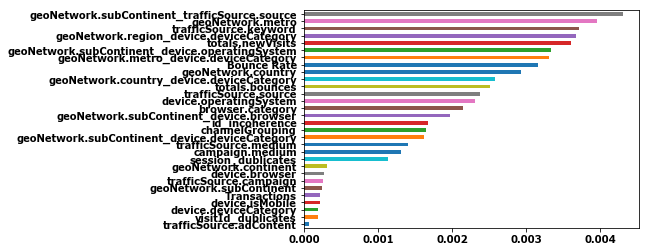

In [58]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

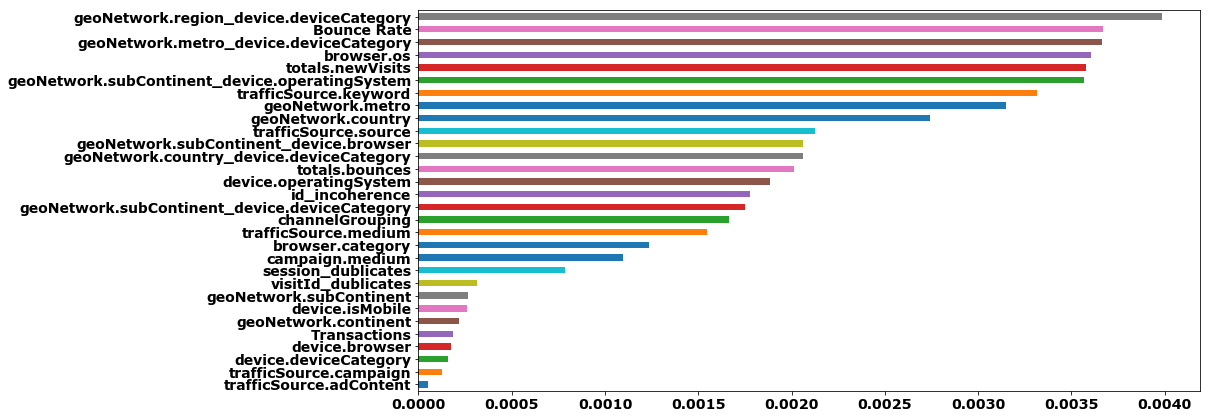

In [136]:
lgbmodel.FI.mean(axis=1).sort_values()[:30].plot(kind="barh")

**User-level**

**Make one user one object:
**

* all features are averaged
* we hope, that categorical features do not change for one user (that's not true :/ )
* categoricals labels are averaged (!!!) and are treated as numerical features (o_O)
* predictions are averaged in multiple ways...

In [59]:
def create_user_df(df):
    agg_data = df[real_cols + cat_cols + ['fullVisitorId']].groupby('fullVisitorId').mean()
    
    pred_list = df[['fullVisitorId', 'lgbpred']].groupby('fullVisitorId').apply(lambda visitor_df: list(visitor_df.lgbpred))\
        .apply(lambda x: {'pred_'+str(i): pred for i, pred in enumerate(x)})
    all_predictions = pd.DataFrame(list(pred_list.values), index=agg_data.index)
    feats = all_predictions.columns

    all_predictions['t_mean'] = all_predictions.mean(axis=1)
    all_predictions['t_median'] = all_predictions.median(axis=1)   # including t_mean as one of the elements? well, ok
    all_predictions['t_sum_log'] = all_predictions.sum(axis=1)
    all_predictions['t_sum_act'] = all_predictions.fillna(0).sum(axis=1)
    all_predictions['t_nb_sess'] = all_predictions.isnull().sum(axis=1)

    full_data = pd.concat([agg_data, all_predictions], axis=1).astype(float)
    full_data['fullVisitorId'] = full_data.index
    del agg_data, all_predictions
    gc.collect()
    return full_data

In [60]:
train.head()

,channelGrouping,fullVisitorId,visitNumber,device.browser,device.deviceCategory,device.isMobile,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,trafficSource.adContent,trafficSource.campaign,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source,Sessions,Avg. Session Duration,Bounce Rate,Revenue,Transactions,Goal Conversion Rate,id_incoherence,visitId_dublicates,session_dublicates,weekday,time,prev_session,next_session,source.country,campaign.medium,browser.category,browser.os,device_deviceCategory_channelGrouping,channelGrouping_browser,channelGrouping_OS,geoNetwork.city_device.browser,geoNetwork.city_device.deviceCategory,geoNetwork.city_device.operatingSystem,geoNetwork.city_trafficSource.source,geoNetwork.continent_device.browser,geoNetwork.continent_device.deviceCategory,geoNetwork.continent_device.operatingSystem,geoNetwork.continent_trafficSource.source,geoNetwork.country_device.browser,geoNetwork.country_device.deviceCategory,geoNetwork.country_device.operatingSystem,geoNetwork.country_trafficSource.source,geoNetwork.metro_device.browser,geoNetwork.metro_device.deviceCategory,geoNetwork.metro_device.operatingSystem,geoNetwork.metro_trafficSource.source,geoNetwork.networkDomain_device.browser,geoNetwork.networkDomain_device.deviceCategory,geoNetwork.networkDomain_device.operatingSystem,geoNetwork.networkDomain_trafficSource.source,geoNetwork.region_device.browser,geoNetwork.region_device.deviceCategory,geoNetwork.region_device.operatingSystem,geoNetwork.region_trafficSource.source,geoNetwork.subContinent_device.browser,geoNetwork.subContinent_device.deviceCategory,geoNetwork.subContinent_device.operatingSystem,geoNetwork.subContinent_trafficSource.source,content.source,medium.source,usermean_totals.hits,usermean_totals.pageviews,usermax_visitNumber,lgbpred
visitStartTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-08-01 07:00:12,2,0423043652415339154,3.0,9,1,1.0,7,102,2,77,25,0,91,9,1.0,1.0,0.0,1.0,0.0,0,1,1.0,4,0,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25212.0,-2562048.0,-2562048.0,77,1,30,45,10,76,57,1184,307,805,2146,38,7,25,48,1005,232,666,1642,313,76,199,615,9,1,7,0,1091,274,734,1885,136,28,88,208,77,77,1.0,1.0,3.0,0.0
2016-08-01 07:04:26,7,8294721032567046680,1.0,2,0,0.0,5,102,3,71,25,109,91,12,1.0,1.0,1.0,1.0,0.0,0,1,0.0,4,6,23,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25466.0,-2562048.0,-2562048.0,1739,7,5,7,7,21,54,1177,306,803,2173,46,9,32,103,917,213,610,1534,306,75,197,642,1220,326,875,2198,1084,273,732,1912,174,36,113,318,1739,1919,1.0,1.0,1.0,0.0
2016-08-01 07:04:41,4,7718623669497357235,1.0,0,2,1.0,1,102,2,77,25,0,91,9,0.0,5.0,1.0,5.0,0.0,0,1,0.0,3,4,52,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25481.0,-2562048.0,-2562048.0,727,5,1,0,20,3,12,1175,308,799,2155,29,8,19,57,996,233,660,1651,304,77,193,624,0,2,1,9,1082,275,728,1894,127,29,82,217,727,500,5.0,5.0,1.0,0.0
2016-08-01 07:06:01,4,4798058133221713505,1.0,2,0,0.0,5,102,2,11,25,16,91,9,0.0,9.0,1.0,7.0,0.0,0,1,0.0,3,4,52,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25561.0,-2562048.0,-2562048.0,661,5,5,7,4,18,51,1177,306,803,2155,31,6,23,57,149,33,102,238,306,75,197,624,181,48,139,327,1084,273,732,1894,129,27,86,217,661,434,9.0,7.0,1.0,0.0
2016-08-01 07:06:10,2,5076747981380011349,1.0,2,0,0.0,5,75,3,53,0,67,52,12,1.0,1.0,1.0,1.0,0.0,0,1,1.0,4,0,52,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0,25570.0,-2562048.0,-2562048.0,53,1,5,7,2,16,49,873,225,601,1563,46,9,32,76,684,159,455,1109,2,0,5,0,749,200,532,1330,622,156,424,1041,174,36,113,291,53,53,1.0,1.0,1.0,0.0


In [61]:
user_train = create_user_df(train)
user_test = create_user_df(test)

In [62]:
features = list(user_train.columns)[:-1]  # don't include "fullVisitorId"
user_train["totals.transactionRevenue"] = train[['fullVisitorId', 'totals.transactionRevenue']].groupby('fullVisitorId').sum()

In [63]:
for f in features:
    if f not in user_test.columns:
        user_test[f] = np.nan

**Meta-models**

In [64]:
Kfolder = KFoldValidation(user_train)

In [65]:
lgbmodel = lgb.LGBMRegressor(n_estimators=1500, objective="regression", metric="rmse", num_leaves=31, min_child_samples=100,
                      learning_rate=0.03, bagging_fraction=0.7, feature_fraction=0.55, bagging_frequency=6, 
                      bagging_seed=2019, subsample=.9, colsample_bytree=.9, use_best_model=True)

In [66]:
Kfolder.validate(user_train, user_test, features, lgbmodel, name="lgbfinal", prepare_stacking=True)

Fold  0 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50536
[200]	valid_0's rmse: 1.50012
Early stopping, best iteration is:
[208]	valid_0's rmse: 1.50002
Fold  0  error:  1.4996719178120554
Fold  0  score:  1.4996719178120554
Fold  1 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50844
[200]	valid_0's rmse: 1.50591
Early stopping, best iteration is:
[159]	valid_0's rmse: 1.50516
Fold  1  error:  1.5049508930664641
Fold  1  score:  1.5049508930664641
Fold  2 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.50757
[200]	valid_0's rmse: 1.5024
Early stopping, best iteration is:
[206]	valid_0's rmse: 1.50228
Fold  2  error:  1.5021510019077964
Fold  2  score:  1.5021510019077964
Fold  3 :
Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 1.48397
[200]	valid_0's rmse: 1.47761
Early stopping, best iteration is:
[214]	valid_0's rmse: 1.477

1.4993980594372773

In [67]:
xgbmodel = xgb.XGBRegressor(max_depth=22, learning_rate=0.02, n_estimators=1000, 
                                         objective='reg:linear', gamma=1.45, seed=2019, silent=False,
                                        subsample=0.67, colsample_bytree=0.054, colsample_bylevel=0.50)

In [68]:
Kfolder.validate(user_train, user_test, features, xgbmodel, name="xgbfinal", prepare_stacking=True)

Fold  0 :
[22:51:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 8 pruned nodes, max_depth=19
[0]	validation_0-rmse:2.10112
Will train until validation_0-rmse hasn't improved in 50 rounds.
[22:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3928 extra nodes, 106 pruned nodes, max_depth=22
[22:51:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3974 extra nodes, 4 pruned nodes, max_depth=22
[22:51:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2474 extra nodes, 142 pruned nodes, max_depth=22
[22:51:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 112 extra nodes, 8 pruned nodes, max_depth=15
[22:51:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 

[22:52:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1280 extra nodes, 172 pruned nodes, max_depth=20
[22:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1334 extra nodes, 288 pruned nodes, max_depth=22
[22:52:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 248 extra nodes, 60 pruned nodes, max_depth=20
[22:52:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 720 extra nodes, 174 pruned nodes, max_depth=22
[22:52:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3164 extra nodes, 750 pruned nodes, max_depth=22
[22:52:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4148 extra nodes, 1650 pruned nodes, max_depth=22
[22:52:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[22:52:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8318 extra nodes, 7996 pruned nodes, max_depth=22
[22:52:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 858 extra nodes, 302 pruned nodes, max_depth=17
[22:52:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5560 extra nodes, 4668 pruned nodes, max_depth=22
[22:52:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 366 extra nodes, 70 pruned nodes, max_depth=19
[22:52:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1476 extra nodes, 1634 pruned nodes, max_depth=22
[22:52:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3588 extra nodes, 1270 pruned nodes, max_depth=20
[22:52:58] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[22:53:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 690 extra nodes, 328 pruned nodes, max_depth=22
[22:53:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2180 extra nodes, 3836 pruned nodes, max_depth=22
[22:53:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 820 extra nodes, 206 pruned nodes, max_depth=16
[22:53:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1810 extra nodes, 1798 pruned nodes, max_depth=19
[22:53:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3494 extra nodes, 2274 pruned nodes, max_depth=21
[22:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1960 extra nodes, 404 pruned nodes, max_depth=21
[22:53:41] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[22:54:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6130 extra nodes, 3626 pruned nodes, max_depth=22
[22:54:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4658 extra nodes, 11840 pruned nodes, max_depth=22
[22:54:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5726 extra nodes, 15200 pruned nodes, max_depth=22
[22:54:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 24 pruned nodes, max_depth=18
[22:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7994 extra nodes, 5916 pruned nodes, max_depth=22
[22:54:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 250 extra nodes, 280 pruned nodes, max_depth=22
[22:54:29] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[22:55:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4074 extra nodes, 2170 pruned nodes, max_depth=22
[22:55:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2814 extra nodes, 3248 pruned nodes, max_depth=22
[22:55:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8500 extra nodes, 12496 pruned nodes, max_depth=22
[22:55:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2042 extra nodes, 1766 pruned nodes, max_depth=22
[22:55:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1682 extra nodes, 632 pruned nodes, max_depth=22
[22:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3338 extra nodes, 1540 pruned nodes, max_depth=22
[22:55:14] C:\Users\Administrator\Desktop\xgboost\src\tree

[22:55:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 528 extra nodes, 114 pruned nodes, max_depth=22
[22:55:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 116 extra nodes, 188 pruned nodes, max_depth=22
[22:55:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 376 extra nodes, 248 pruned nodes, max_depth=22
[22:55:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3566 extra nodes, 7700 pruned nodes, max_depth=22
[22:56:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1054 extra nodes, 1156 pruned nodes, max_depth=22
[22:56:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5790 extra nodes, 11188 pruned nodes, max_depth=22
[22:56:02] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[22:56:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1620 extra nodes, 3574 pruned nodes, max_depth=22
[22:56:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3288 extra nodes, 8454 pruned nodes, max_depth=22
[22:56:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4226 extra nodes, 7434 pruned nodes, max_depth=22
[22:56:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2072 extra nodes, 3930 pruned nodes, max_depth=22
[22:56:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 66 extra nodes, 162 pruned nodes, max_depth=13
[22:56:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4416 extra nodes, 4714 pruned nodes, max_depth=22
[22:56:50] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[22:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 52 pruned nodes, max_depth=10
[22:57:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 370 extra nodes, 328 pruned nodes, max_depth=22
[22:57:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1964 extra nodes, 1620 pruned nodes, max_depth=22
[22:57:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 80 extra nodes, 188 pruned nodes, max_depth=18
[22:57:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4832 extra nodes, 4348 pruned nodes, max_depth=22
[22:57:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2338 extra nodes, 3038 pruned nodes, max_depth=22
[22:57:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[22:58:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 516 extra nodes, 1122 pruned nodes, max_depth=22
[22:58:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 510 extra nodes, 108 pruned nodes, max_depth=22
[22:58:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1664 extra nodes, 4580 pruned nodes, max_depth=22
[22:58:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2258 extra nodes, 1640 pruned nodes, max_depth=22
[22:58:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 240 pruned nodes, max_depth=15
[22:58:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1716 extra nodes, 3404 pruned nodes, max_depth=22
[22:58:22] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[22:59:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 258 extra nodes, 256 pruned nodes, max_depth=20
[22:59:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 276 extra nodes, 76 pruned nodes, max_depth=22
[22:59:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 808 pruned nodes, max_depth=22
[22:59:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 334 extra nodes, 532 pruned nodes, max_depth=22
[22:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4822 extra nodes, 7178 pruned nodes, max_depth=22
[22:59:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 254 extra nodes, 302 pruned nodes, max_depth=22
[22:59:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[22:59:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1346 extra nodes, 3038 pruned nodes, max_depth=21
[22:59:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1454 extra nodes, 6680 pruned nodes, max_depth=22
[22:59:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1462 extra nodes, 3434 pruned nodes, max_depth=22
[22:59:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 480 extra nodes, 620 pruned nodes, max_depth=22
[22:59:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 4178 pruned nodes, max_depth=22
[22:59:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5586 extra nodes, 21014 pruned nodes, max_depth=22
[22:59:53] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:03:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8088 extra nodes, 2498 pruned nodes, max_depth=22
[23:03:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7350 extra nodes, 1254 pruned nodes, max_depth=22
[23:03:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4250 extra nodes, 916 pruned nodes, max_depth=22
[23:03:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1084 extra nodes, 118 pruned nodes, max_depth=22
[23:03:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1914 extra nodes, 384 pruned nodes, max_depth=22
[23:03:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[23:03:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[23:04:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1116 extra nodes, 412 pruned nodes, max_depth=21
[23:04:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3074 extra nodes, 688 pruned nodes, max_depth=22
[23:04:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4154 extra nodes, 3132 pruned nodes, max_depth=22
[23:04:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 426 extra nodes, 144 pruned nodes, max_depth=16
[23:04:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2454 extra nodes, 1612 pruned nodes, max_depth=22
[23:04:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 570 extra nodes, 232 pruned nodes, max_depth=15
[23:04:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1512 extra nodes, 868 pruned nodes, max_depth=22
[23:04:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 288 extra nodes, 50 pruned nodes, max_depth=12
[23:04:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3110 extra nodes, 7006 pruned nodes, max_depth=22
[23:05:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5230 extra nodes, 6540 pruned nodes, max_depth=22
[23:05:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2038 extra nodes, 2326 pruned nodes, max_depth=22
[23:05:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2768 extra nodes, 2048 pruned nodes, max_depth=22
[23:05:03] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:05:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2156 extra nodes, 2330 pruned nodes, max_depth=22
[200]	validation_0-rmse:1.56539
[23:05:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1796 extra nodes, 2140 pruned nodes, max_depth=22
[23:05:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6910 extra nodes, 11784 pruned nodes, max_depth=22
[23:05:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 434 extra nodes, 176 pruned nodes, max_depth=22
[23:05:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 668 extra nodes, 164 pruned nodes, max_depth=20
[23:05:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2386 extra nodes, 336 pruned nodes, max_depth=22
[23:05:46] C:\Users\Administra

[23:06:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4346 extra nodes, 3092 pruned nodes, max_depth=22
[23:06:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2240 extra nodes, 2324 pruned nodes, max_depth=22
[23:06:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 228 extra nodes, 66 pruned nodes, max_depth=17
[23:06:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8752 extra nodes, 16638 pruned nodes, max_depth=22
[23:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3474 extra nodes, 2712 pruned nodes, max_depth=22
[23:06:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 30 pruned nodes, max_depth=8
[23:06:33] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:07:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2062 extra nodes, 2070 pruned nodes, max_depth=21
[23:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 798 extra nodes, 344 pruned nodes, max_depth=22
[23:07:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 420 extra nodes, 320 pruned nodes, max_depth=22
[23:07:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 468 extra nodes, 232 pruned nodes, max_depth=20
[23:07:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 1546 pruned nodes, max_depth=22
[23:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 536 extra nodes, 198 pruned nodes, max_depth=22
[23:07:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[23:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3180 extra nodes, 3604 pruned nodes, max_depth=22
[23:08:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 366 pruned nodes, max_depth=17
[23:08:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4432 extra nodes, 666 pruned nodes, max_depth=22
[23:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 108 pruned nodes, max_depth=10
[23:08:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2284 extra nodes, 7840 pruned nodes, max_depth=22
[23:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4446 extra nodes, 8956 pruned nodes, max_depth=22
[23:08:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:08:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1392 extra nodes, 786 pruned nodes, max_depth=22
[23:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4298 extra nodes, 3436 pruned nodes, max_depth=22
[23:08:49] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 870 extra nodes, 1090 pruned nodes, max_depth=22
[23:08:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3984 extra nodes, 3154 pruned nodes, max_depth=22
[23:08:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 546 extra nodes, 268 pruned nodes, max_depth=18
[23:08:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 536 pruned nodes, max_depth=22
[23:08:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:09:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1014 extra nodes, 1918 pruned nodes, max_depth=22
[23:09:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1112 extra nodes, 2526 pruned nodes, max_depth=22
[23:09:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2692 extra nodes, 1752 pruned nodes, max_depth=22
[23:09:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 994 extra nodes, 2950 pruned nodes, max_depth=22
[23:09:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 632 extra nodes, 2520 pruned nodes, max_depth=22
[23:09:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 710 extra nodes, 594 pruned nodes, max_depth=22
[23:09:39] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:10:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1504 extra nodes, 522 pruned nodes, max_depth=22
[23:10:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 322 pruned nodes, max_depth=22
[23:10:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1222 extra nodes, 2148 pruned nodes, max_depth=22
[23:10:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1962 extra nodes, 1642 pruned nodes, max_depth=22
[23:10:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2830 extra nodes, 774 pruned nodes, max_depth=22
[23:10:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3362 extra nodes, 4622 pruned nodes, max_depth=22
[23:10:23] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:11:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 534 extra nodes, 938 pruned nodes, max_depth=19
[23:11:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2162 extra nodes, 3102 pruned nodes, max_depth=22
[23:11:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 968 extra nodes, 3046 pruned nodes, max_depth=22
[23:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2240 extra nodes, 3780 pruned nodes, max_depth=22
[23:11:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1244 extra nodes, 754 pruned nodes, max_depth=22
[23:11:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3176 extra nodes, 1538 pruned nodes, max_depth=22
[23:11:11] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:11:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 46 pruned nodes, max_depth=0
[23:11:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3126 extra nodes, 7414 pruned nodes, max_depth=22
[23:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1312 extra nodes, 1398 pruned nodes, max_depth=22
[23:11:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2478 extra nodes, 958 pruned nodes, max_depth=22
[23:11:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 172 extra nodes, 114 pruned nodes, max_depth=22
[23:11:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3704 extra nodes, 4070 pruned nodes, max_depth=22
[23:11:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[23:15:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 2 pruned nodes, max_depth=7
[23:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6176 extra nodes, 1740 pruned nodes, max_depth=22
[23:15:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 976 extra nodes, 90 pruned nodes, max_depth=19
[23:15:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 818 extra nodes, 182 pruned nodes, max_depth=22
[23:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 26 pruned nodes, max_depth=17
[23:15:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 18 pruned nodes, max_depth=19
[23:15:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc

[23:16:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1570 extra nodes, 552 pruned nodes, max_depth=20
[23:16:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 918 extra nodes, 418 pruned nodes, max_depth=22
[23:16:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 280 extra nodes, 88 pruned nodes, max_depth=14
[23:16:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1952 extra nodes, 554 pruned nodes, max_depth=22
[23:16:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4120 extra nodes, 2630 pruned nodes, max_depth=22
[23:16:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4582 extra nodes, 3400 pruned nodes, max_depth=22
[23:16:42] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:17:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7290 extra nodes, 7130 pruned nodes, max_depth=22
[23:17:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1150 extra nodes, 980 pruned nodes, max_depth=22
[23:17:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2382 extra nodes, 3784 pruned nodes, max_depth=22
[23:17:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2552 extra nodes, 866 pruned nodes, max_depth=22
[23:17:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1788 extra nodes, 1762 pruned nodes, max_depth=22
[23:17:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8406 extra nodes, 11786 pruned nodes, max_depth=22
[23:17:32] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:18:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 834 extra nodes, 312 pruned nodes, max_depth=22
[23:18:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 192 extra nodes, 42 pruned nodes, max_depth=11
[23:18:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1268 extra nodes, 632 pruned nodes, max_depth=22
[23:18:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1814 extra nodes, 3756 pruned nodes, max_depth=22
[23:18:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2598 extra nodes, 1360 pruned nodes, max_depth=22
[200]	validation_0-rmse:1.55154
[23:18:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5038 extra nodes, 6900 pruned nodes, max_depth=22
[23:18:17] C:\Users\Administrato

[23:18:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2672 extra nodes, 1314 pruned nodes, max_depth=22
[23:18:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3008 extra nodes, 1572 pruned nodes, max_depth=22
[23:18:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 2416 pruned nodes, max_depth=22
[23:18:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 466 extra nodes, 226 pruned nodes, max_depth=18
[23:19:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2650 extra nodes, 5734 pruned nodes, max_depth=22
[23:19:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3768 extra nodes, 6334 pruned nodes, max_depth=22
[23:19:02] C:\Users\Administrator\Desktop\xgboost\src\tree\u

[23:19:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 24 pruned nodes, max_depth=1
[23:19:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1512 extra nodes, 1660 pruned nodes, max_depth=22
[23:19:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 26 pruned nodes, max_depth=17
[23:19:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2910 extra nodes, 3924 pruned nodes, max_depth=22
[23:19:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 346 extra nodes, 380 pruned nodes, max_depth=22
[23:19:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 520 extra nodes, 344 pruned nodes, max_depth=22
[23:19:46] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune

[23:20:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2398 extra nodes, 5982 pruned nodes, max_depth=22
[23:20:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2294 extra nodes, 1660 pruned nodes, max_depth=22
[23:20:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 290 extra nodes, 136 pruned nodes, max_depth=16
[23:20:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 306 pruned nodes, max_depth=22
[23:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5706 extra nodes, 10564 pruned nodes, max_depth=22
[23:20:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 110 extra nodes, 122 pruned nodes, max_depth=21
[23:20:34] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:21:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 158 pruned nodes, max_depth=22
[23:21:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4450 extra nodes, 2690 pruned nodes, max_depth=22
[23:21:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4498 extra nodes, 6276 pruned nodes, max_depth=22
[23:21:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 828 extra nodes, 690 pruned nodes, max_depth=21
[23:21:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 86 extra nodes, 38 pruned nodes, max_depth=20
[23:21:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1174 extra nodes, 580 pruned nodes, max_depth=22
[23:21:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[23:22:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4874 extra nodes, 5264 pruned nodes, max_depth=22
[23:22:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2208 extra nodes, 7456 pruned nodes, max_depth=22
[23:22:02] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 64 extra nodes, 120 pruned nodes, max_depth=19
[23:22:03] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 558 extra nodes, 170 pruned nodes, max_depth=22
[23:22:04] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4340 extra nodes, 6220 pruned nodes, max_depth=21
[23:22:05] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 574 extra nodes, 692 pruned nodes, max_depth=22
[23:22:06] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:22:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1968 extra nodes, 2030 pruned nodes, max_depth=22
[23:22:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 130 pruned nodes, max_depth=16
[23:22:48] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3670 extra nodes, 2090 pruned nodes, max_depth=22
[23:22:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5938 extra nodes, 9688 pruned nodes, max_depth=22
[23:22:50] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2036 extra nodes, 840 pruned nodes, max_depth=22
[23:22:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1820 extra nodes, 7162 pruned nodes, max_depth=22
[23:22:52] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:26:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 406 extra nodes, 8 pruned nodes, max_depth=17
[23:26:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=8
[23:26:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 310 extra nodes, 10 pruned nodes, max_depth=18
[23:26:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2748 extra nodes, 296 pruned nodes, max_depth=22
[23:26:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2590 extra nodes, 182 pruned nodes, max_depth=22
[23:26:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4644 extra nodes, 102 pruned nodes, max_depth=22
[23:26:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[23:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1378 extra nodes, 184 pruned nodes, max_depth=22
[23:26:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 130 extra nodes, 24 pruned nodes, max_depth=17
[23:26:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8602 extra nodes, 3242 pruned nodes, max_depth=22
[23:26:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 46 pruned nodes, max_depth=18
[23:26:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1284 extra nodes, 468 pruned nodes, max_depth=22
[23:27:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 152 pruned nodes, max_depth=22
[23:27:01] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[23:27:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 160 extra nodes, 20 pruned nodes, max_depth=15
[23:27:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 26 pruned nodes, max_depth=9
[23:27:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 518 extra nodes, 84 pruned nodes, max_depth=22
[23:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 868 extra nodes, 580 pruned nodes, max_depth=22
[23:27:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 386 extra nodes, 82 pruned nodes, max_depth=22
[23:27:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6092 extra nodes, 3792 pruned nodes, max_depth=22
[23:27:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.c

[23:28:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1990 extra nodes, 1482 pruned nodes, max_depth=22
[23:28:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 488 extra nodes, 324 pruned nodes, max_depth=22
[23:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2454 extra nodes, 872 pruned nodes, max_depth=22
[23:28:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 4 pruned nodes, max_depth=10
[23:28:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8406 extra nodes, 4268 pruned nodes, max_depth=22
[23:28:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3720 extra nodes, 666 pruned nodes, max_depth=22
[23:28:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_

[23:29:06] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 14 pruned nodes, max_depth=7
[23:29:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1844 extra nodes, 802 pruned nodes, max_depth=22
[23:29:07] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 292 extra nodes, 108 pruned nodes, max_depth=14
[23:29:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2848 extra nodes, 916 pruned nodes, max_depth=22
[23:29:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1396 extra nodes, 1678 pruned nodes, max_depth=22
[23:29:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 242 extra nodes, 354 pruned nodes, max_depth=22
[23:29:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pr

[23:29:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2990 extra nodes, 2916 pruned nodes, max_depth=22
[23:29:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 776 extra nodes, 560 pruned nodes, max_depth=22
[23:29:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 298 extra nodes, 192 pruned nodes, max_depth=19
[23:29:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1264 extra nodes, 966 pruned nodes, max_depth=22
[23:29:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6612 extra nodes, 7166 pruned nodes, max_depth=22
[23:29:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 42 pruned nodes, max_depth=5
[23:29:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_p

[23:30:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1468 extra nodes, 2238 pruned nodes, max_depth=22
[23:30:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4764 extra nodes, 11036 pruned nodes, max_depth=22
[23:30:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 700 extra nodes, 496 pruned nodes, max_depth=22
[23:30:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2678 extra nodes, 5378 pruned nodes, max_depth=22
[23:30:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1812 extra nodes, 352 pruned nodes, max_depth=22
[23:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 482 extra nodes, 252 pruned nodes, max_depth=22
[23:30:44] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:31:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5256 extra nodes, 10636 pruned nodes, max_depth=22
[23:31:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1844 extra nodes, 1318 pruned nodes, max_depth=22
[23:31:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2070 extra nodes, 3044 pruned nodes, max_depth=22
[23:31:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3434 extra nodes, 2638 pruned nodes, max_depth=22
[23:31:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 768 extra nodes, 844 pruned nodes, max_depth=22
[23:31:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4272 extra nodes, 2134 pruned nodes, max_depth=22
[23:31:32] C:\Users\Administrator\Desktop\xgboost\src\tree\

[23:32:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3476 extra nodes, 4200 pruned nodes, max_depth=22
[23:32:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 450 extra nodes, 118 pruned nodes, max_depth=22
[23:32:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2688 extra nodes, 7362 pruned nodes, max_depth=22
[23:32:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3032 extra nodes, 2382 pruned nodes, max_depth=22
[23:32:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 230 extra nodes, 416 pruned nodes, max_depth=21
[23:32:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 120 extra nodes, 36 pruned nodes, max_depth=22
[23:32:19] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:32:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 20 pruned nodes, max_depth=8
[23:32:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3374 extra nodes, 4564 pruned nodes, max_depth=22
[23:32:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1192 extra nodes, 928 pruned nodes, max_depth=22
[23:32:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 1368 pruned nodes, max_depth=22
[23:32:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1520 extra nodes, 1124 pruned nodes, max_depth=22
[23:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1016 extra nodes, 2274 pruned nodes, max_depth=22
[23:33:00] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:33:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 10 extra nodes, 56 pruned nodes, max_depth=5
[23:33:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 598 extra nodes, 1116 pruned nodes, max_depth=15
[23:33:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3620 extra nodes, 5098 pruned nodes, max_depth=22
[23:33:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1466 extra nodes, 3874 pruned nodes, max_depth=22
[23:33:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2348 extra nodes, 1520 pruned nodes, max_depth=22
[23:33:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5864 extra nodes, 13378 pruned nodes, max_depth=22
[23:33:44] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:34:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5954 extra nodes, 12596 pruned nodes, max_depth=22
[23:34:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 698 extra nodes, 480 pruned nodes, max_depth=22
[23:34:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 900 extra nodes, 1640 pruned nodes, max_depth=22
[23:34:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1278 extra nodes, 562 pruned nodes, max_depth=22
[23:34:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5858 extra nodes, 5014 pruned nodes, max_depth=22
[23:34:34] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4588 extra nodes, 3144 pruned nodes, max_depth=22
[23:34:35] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:35:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1626 extra nodes, 2624 pruned nodes, max_depth=22
[23:35:19] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 86 pruned nodes, max_depth=13
[23:35:20] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4016 extra nodes, 2572 pruned nodes, max_depth=22
[23:35:21] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 326 pruned nodes, max_depth=10
[23:35:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 7058 extra nodes, 7156 pruned nodes, max_depth=22
[23:35:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1766 extra nodes, 2732 pruned nodes, max_depth=22
[23:35:24] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2322 extra nodes, 250 pruned nodes, max_depth=22
[23:39:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 114 extra nodes, 10 pruned nodes, max_depth=12
[23:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1304 extra nodes, 228 pruned nodes, max_depth=22
[23:39:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 8 pruned nodes, max_depth=10
[23:39:28] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5584 extra nodes, 996 pruned nodes, max_depth=22
[23:39:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4808 extra nodes, 782 pruned nodes, max_depth=22
[23:39:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_pru

[23:40:08] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6464 extra nodes, 2558 pruned nodes, max_depth=22
[23:40:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 830 extra nodes, 196 pruned nodes, max_depth=22
[23:40:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5120 extra nodes, 3346 pruned nodes, max_depth=22
[23:40:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8270 extra nodes, 6036 pruned nodes, max_depth=22
[23:40:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4992 extra nodes, 4536 pruned nodes, max_depth=22
[23:40:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1220 extra nodes, 820 pruned nodes, max_depth=22
[23:40:14] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:40:51] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 2452 pruned nodes, max_depth=22
[23:40:52] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 6292 extra nodes, 6048 pruned nodes, max_depth=22
[23:40:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8012 extra nodes, 6502 pruned nodes, max_depth=22
[23:40:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 398 extra nodes, 216 pruned nodes, max_depth=22
[23:40:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 104 extra nodes, 16 pruned nodes, max_depth=11
[23:40:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4338 extra nodes, 1216 pruned nodes, max_depth=22
[23:40:56] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:41:35] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 1292 pruned nodes, max_depth=22
[23:41:36] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 348 extra nodes, 74 pruned nodes, max_depth=21
[23:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4896 extra nodes, 6222 pruned nodes, max_depth=22
[23:41:37] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2082 extra nodes, 1942 pruned nodes, max_depth=22
[23:41:38] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 756 extra nodes, 1378 pruned nodes, max_depth=22
[200]	validation_0-rmse:1.56557
[23:41:39] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5848 extra nodes, 15966 pruned nodes, max_depth=22
[23:41:40] C:\Users\Administra

[23:42:22] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2732 extra nodes, 1158 pruned nodes, max_depth=22
[23:42:23] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1762 extra nodes, 180 pruned nodes, max_depth=22
[23:42:24] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 134 extra nodes, 60 pruned nodes, max_depth=22
[23:42:25] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3290 extra nodes, 3034 pruned nodes, max_depth=22
[23:42:26] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3464 extra nodes, 898 pruned nodes, max_depth=22
[23:42:27] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1198 extra nodes, 2312 pruned nodes, max_depth=22
[23:42:28] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:43:09] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 878 extra nodes, 406 pruned nodes, max_depth=22
[23:43:10] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1034 extra nodes, 1580 pruned nodes, max_depth=22
[23:43:11] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2632 extra nodes, 3060 pruned nodes, max_depth=22
[23:43:12] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4322 extra nodes, 7620 pruned nodes, max_depth=22
[23:43:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 416 extra nodes, 312 pruned nodes, max_depth=22
[23:43:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1776 extra nodes, 3738 pruned nodes, max_depth=22
[23:43:15] C:\Users\Administrator\Desktop\xgboost\src\tree\upd

[23:43:53] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 300 extra nodes, 368 pruned nodes, max_depth=22
[23:43:54] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1136 extra nodes, 852 pruned nodes, max_depth=22
[23:43:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 106 extra nodes, 264 pruned nodes, max_depth=16
[23:43:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2808 extra nodes, 2412 pruned nodes, max_depth=22
[23:43:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 8544 extra nodes, 10508 pruned nodes, max_depth=22
[23:43:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 136 extra nodes, 104 pruned nodes, max_depth=21
[23:43:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updat

[23:44:40] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4894 extra nodes, 12098 pruned nodes, max_depth=22
[23:44:41] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3150 extra nodes, 2216 pruned nodes, max_depth=22
[23:44:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 4156 extra nodes, 1056 pruned nodes, max_depth=22
[23:44:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2426 extra nodes, 2818 pruned nodes, max_depth=22
[23:44:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 212 extra nodes, 200 pruned nodes, max_depth=22
[23:44:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 232 extra nodes, 442 pruned nodes, max_depth=22
[23:44:46] C:\Users\Administrator\Desktop\xgboost\src\tree\up

[23:45:29] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1448 extra nodes, 1182 pruned nodes, max_depth=22
[23:45:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3564 extra nodes, 3934 pruned nodes, max_depth=22
[23:45:30] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2320 extra nodes, 1006 pruned nodes, max_depth=22
[23:45:31] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1200 extra nodes, 2556 pruned nodes, max_depth=22
[23:45:32] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 2754 extra nodes, 6220 pruned nodes, max_depth=22
[23:45:33] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 66 pruned nodes, max_depth=7
[23:45:34] C:\Users\Administrator\Desktop\xgboost\src\tree\upda

[23:46:13] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1750 extra nodes, 1488 pruned nodes, max_depth=21
[23:46:14] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 508 extra nodes, 482 pruned nodes, max_depth=22
[23:46:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 1740 pruned nodes, max_depth=22
[23:46:15] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 34 pruned nodes, max_depth=12
[23:46:16] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 3004 extra nodes, 3304 pruned nodes, max_depth=22
[23:46:17] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 1194 extra nodes, 588 pruned nodes, max_depth=22
[23:46:18] C:\Users\Administrator\Desktop\xgboost\src\tree\updater

[23:46:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5768 extra nodes, 11984 pruned nodes, max_depth=22
[23:46:55] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 814 extra nodes, 658 pruned nodes, max_depth=22
[23:46:56] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 592 extra nodes, 594 pruned nodes, max_depth=22
[23:46:57] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 762 extra nodes, 924 pruned nodes, max_depth=22
[23:46:58] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 5576 extra nodes, 7358 pruned nodes, max_depth=22
[23:46:59] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 936 extra nodes, 556 pruned nodes, max_depth=22
[23:47:00] C:\Users\Administrator\Desktop\xgboost\src\tree\update

[23:47:42] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 84 pruned nodes, max_depth=16
[23:47:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 924 extra nodes, 1802 pruned nodes, max_depth=22
[23:47:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 864 extra nodes, 568 pruned nodes, max_depth=22
[23:47:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 708 extra nodes, 2086 pruned nodes, max_depth=22
[23:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 38 pruned nodes, max_depth=12
[23:47:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 588 extra nodes, 292 pruned nodes, max_depth=22
Stopping. Best iteration:
[575]	validation_0-rmse:1.52884

Fold  4  erro

1.520556754735607

In [69]:
catmodel = cat.CatBoostRegressor(iterations=1000, learning_rate=0.2, depth=7, random_seed=2019)

In [70]:
%%time
Kfolder.validate(user_train, user_test, features, catmodel, name="catfinal", prepare_stacking=True,
                fit_params={"use_best_model": True, "verbose": 100})

Fold  0 :
0:	learn: 1.9236964	test: 1.9264670	best: 1.9264670 (0)	total: 1.93s	remaining: 32m 11s
100:	learn: 1.4266019	test: 1.5057002	best: 1.5029950 (59)	total: 2m 58s	remaining: 26m 26s
200:	learn: 1.3687136	test: 1.5120851	best: 1.5029950 (59)	total: 5m 53s	remaining: 23m 25s
300:	learn: 1.3197060	test: 1.5235265	best: 1.5029950 (59)	total: 8m 49s	remaining: 20m 29s
400:	learn: 1.2791729	test: 1.5266379	best: 1.5029950 (59)	total: 11m 45s	remaining: 17m 33s
500:	learn: 1.2394654	test: 1.5333244	best: 1.5029950 (59)	total: 14m 41s	remaining: 14m 37s
600:	learn: 1.2045530	test: 1.5367237	best: 1.5029950 (59)	total: 17m 35s	remaining: 11m 40s
700:	learn: 1.1727196	test: 1.5395749	best: 1.5029950 (59)	total: 20m 29s	remaining: 8m 44s
800:	learn: 1.1395889	test: 1.5434735	best: 1.5029950 (59)	total: 23m 22s	remaining: 5m 48s
900:	learn: 1.1103935	test: 1.5483071	best: 1.5029950 (59)	total: 26m 17s	remaining: 2m 53s
999:	learn: 1.0825855	test: 1.5520947	best: 1.5029950 (59)	total: 29m 1

1.5010441731890243

**Ensembling dragons**

In [71]:
user_train['PredictedLogRevenue'] = 0.5 * user_train["lgbfinal"] + \
                                    0.1 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.4971240658474372

In [72]:
user_train['PredictedLogRevenue'] = 0.5 * user_train["lgbfinal"] + \
                                    0.1 * user_train["xgbfinal"] + \
                                    0.4 * user_train["catfinal"]
score(user_train, user_train.PredictedLogRevenue)

1.4971240658474372

In [73]:
user_test['PredictedLogRevenue'] = 0.5 * user_test["lgbfinal"] +  0.4 * user_test["catfinal"] + 0.1 * user_test["xgbfinal"]
user_test[['PredictedLogRevenue']].to_csv('leak_check_submission3.csv', index=True)